#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:\\Users\\admin\\Desktop\\DS_yandex\\11_Прогнозирование заказов такси\\taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
display(data.info(), data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Вывод:

Данные загружены и отсортированы по индексу, в качестве которого установлена дата. Пропусков в данных нет.

## Анализ

Ресемплируем данные по одному часу, так как нам требуется предсказывать количество заказов на следующий час.

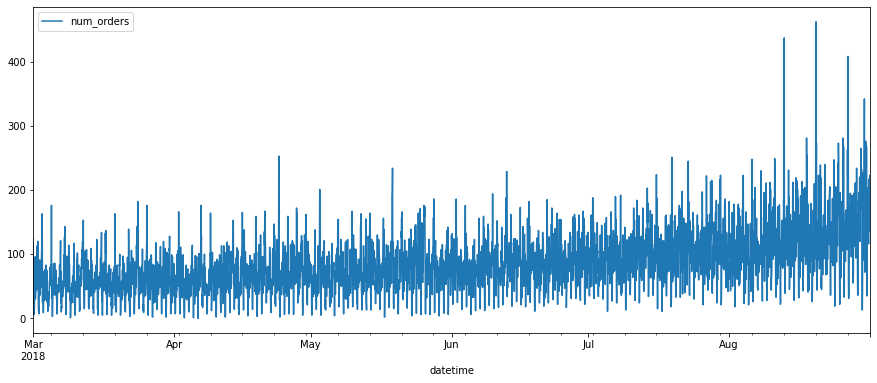

In [4]:
data = data.resample('1H').sum()
data.plot(figsize = (15,6))
plt.show()

Рассмотрим тренд и сезонность.

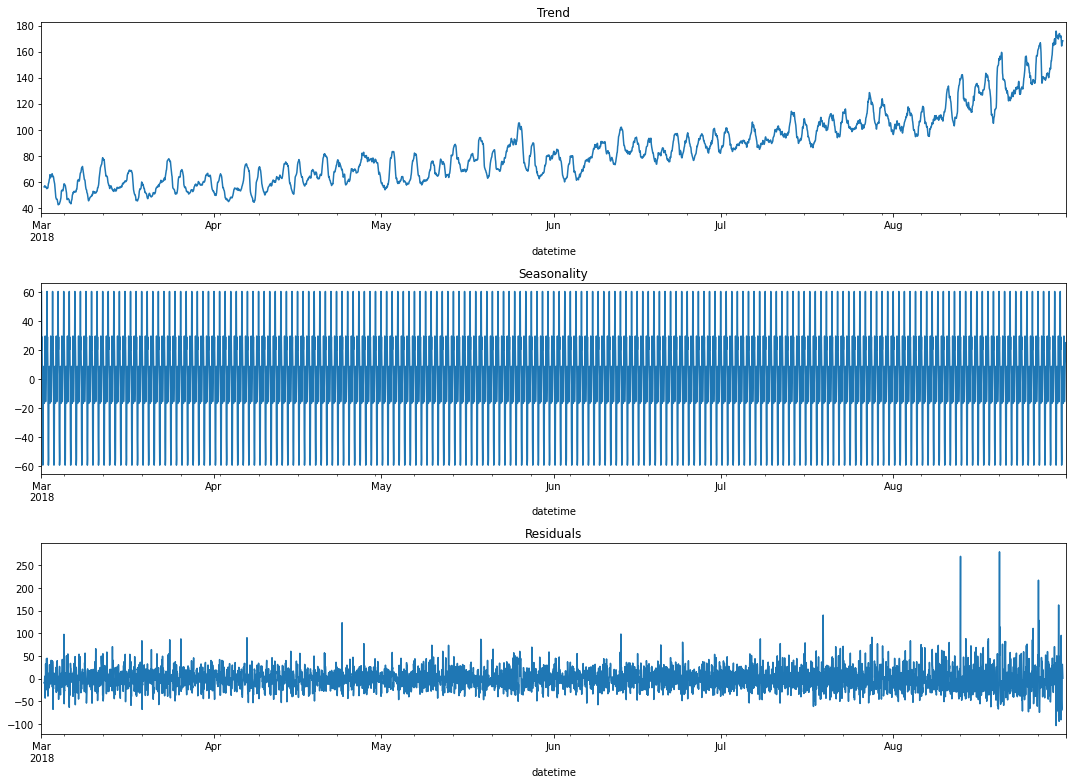

In [5]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Наблюдается тренд увеличения количества заказов такси. 

Уменьшим рассматриваемый временной промежуток до двух дней и рассмотрим сезонность.

Text(0.5, 1.0, 'Seasonality')

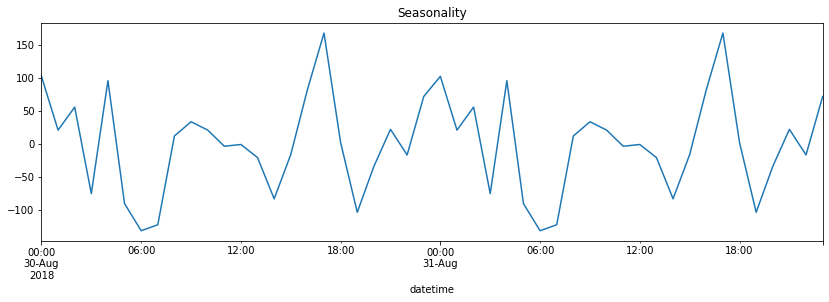

In [6]:
decomposed = seasonal_decompose(data['2018-08-30':'2018-08-31'])
decomposed.seasonal.plot(figsize=(14, 4))
plt.title('Seasonality')

Из графика видно, что максимальный спрос на такси приходится на 17 часов, а минимальный - на 6-7 часов утра.

### Вывод:

Данные проанализированы, тренд указывает на увеличение количества заказов такси, а график сезонности показал, что максимальное количество вызово такси приходится на полночь, а минимальное - на 5-6 часов утра.

## Обучение

### Функция для создания признаков

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)]= data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Данная функция создаст такие признаки как "день недели", "скользящее среднее" и "размер смещения".

### Проверка на адекватность

Для проверки на адекватность создадим 2 модели предсказания:
1. предсказание значения по медиане;
2. предсказание значения по предыдущему значению ряда.

In [8]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state = 12345)

#### Медианная модель

In [9]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE:", mean_squared_error(test, pred_median)**0.5)

RMSE: 87.15277582981295


#### Предсказание по предыдущему значению ряда

In [10]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
RMSE_dummy = mean_squared_error(test, pred_previous)**0.5
print("RMSE:", RMSE_dummy)

RMSE: 58.856486242815066


RMSE у второй модели меньше, значит именно с этим значением мы будем сравнивать наши будущие модели.

### Линейная регрессия

In [11]:
%%time
best_lag_lr = 0
best_rolling_size_lr = 0
best_rmse = 48
for lag in range (1, 100, 10):
    for roll in range(1, 100, 10):        
        data_features = make_features(data, lag, roll)
        train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state = 12345)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        
        regress = LinearRegression()
        tss = TimeSeriesSplit(n_splits = 8)
        regress_params = {'normalize':[True,False]}
        grid = GridSearchCV(regress, 
                            regress_params, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss, 
                            n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse = (-grid.best_score_) ** 0.5   
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag_lr = lag
            best_rolling_size_lr = roll
        
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag_lr, best_rolling_size_lr))
param_lr = grid.best_params_
print('Наилучшие параметры для модели:', param_lr)

RMSE на кроссвалидации: 24.13, Размер смещения: 81.00, Размер скользящего окна: 11.00 
Наилучшие параметры для модели: {'normalize': False}
CPU times: total: 1min 18s
Wall time: 20 s


### Случайный лес

In [12]:
%%time
best_lag_rf = 0
best_rolling_size_rf = 0
best_rmse = 48
for lag in range (51, 61, 10):
    for roll in range(1, 11, 10):
        data_features = make_features(data, lag, roll)
        train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state = 12345)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        
        forest = RandomForestRegressor()
        tss = TimeSeriesSplit(n_splits = 8)
        forest_params = {'max_depth': range(11, 21, 5)}
        grid = GridSearchCV(forest, 
                            forest_params, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss , 
                            n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse = (-grid.best_score_) ** 0.5 
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag_rf = lag
            best_rolling_size_rf = roll
        
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag_rf, best_rolling_size_rf))
params_rf = grid.best_params_
print('Наилучшие параметры для модели:', params_rf)

RMSE на кроссвалидации: 24.10, Размер смещения: 51.00, Размер скользящего окна: 1.00 
Наилучшие параметры для модели: {'max_depth': 16}
CPU times: total: 14.9 s
Wall time: 31.6 s


### CatBoost

In [13]:
%%time
best_lag_cb = 0
best_rolling_size_cb = 0
best_rmse = 48
for lag in range (1, 11, 10):
    for roll in range(31, 41, 10):
        data_features = make_features(data, lag, roll)
        train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state = 12345)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        
        cat = CatBoostRegressor(iterations = 100, verbose = False)
        tss = TimeSeriesSplit(n_splits = 8)
        cat_params = {'learning_rate':[0.1]}
        
        grid = GridSearchCV(cat, 
                            cat_params, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss , 
                            n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse = (-grid.best_score_) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag_cb = lag
            best_rolling_size_cb = roll
                
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag_cb, best_rolling_size_cb))
params_cb = grid.best_params_
print('Наилучшие параметры для модели:', params_cb)

RMSE на кроссвалидации: 23.98, Размер смещения: 1.00, Размер скользящего окна: 31.00 
Наилучшие параметры для модели: {'learning_rate': 0.1}
CPU times: total: 6.61 s
Wall time: 4.99 s


### Вывод

На данном этапе мы обучили две константные модели для проверки наших основных моделей на адекватность. Наилучший результат показала модель, предсказывающая по последнему значению ряда с RMSE = 58,85.

Затем мы последовательно обучили и подобрали наилучшие гиперпараметры следующих моделей. Показатели RMSE на кроссвалидации:
- линейная регрессия: RMSE = 24.23;
- cлучайный лес: RMSE = 24.86;
- CatBoost: RMSE = 23.74.

Все наши модели прошли проверку на адекватность, лучше всего себя проявила **Линейная регрессия**.

## Тестирование

Проверим наши модели на тестовой выборке.

### Линейная регрессия

In [14]:
data_regress = make_features(data, best_lag_lr, best_rolling_size_lr)

train, test = train_test_split(data_regress, shuffle=False, test_size=0.1, random_state = 12345)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

regress_test = LinearRegression(normalize = param_lr['normalize'])
regress_test.fit(features_train, target_train)
test_pred_regress = regress_test.predict(features_test)
rmse_test_regress = (mean_squared_error(target_test,test_pred_regress))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_regress))

RMSE тестовой выборки: 40.94


### Случайный лес

In [15]:
data_forest = make_features(data, best_lag_rf, best_rolling_size_rf)

train, test = train_test_split(data_forest, shuffle = False, test_size=0.1, random_state = 12345)
train = train.dropna()
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test =test['num_orders']

forest_test = RandomForestRegressor(max_depth = params_rf['max_depth'])
forest_test.fit(features_train, target_train)
test_pred_forest = forest_test.predict(features_test)
rmse_test_forest = (mean_squared_error(target_test,test_pred_forest))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_forest))

RMSE тестовой выборки: 40.66


### CatBoost

In [16]:
data_cat = make_features(data, best_lag_cb, best_rolling_size_cb)

train, test = train_test_split(data_cat, shuffle=False, test_size=0.1, random_state = 12345)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

cat_test = CatBoostRegressor(iterations = 100, verbose = False, learning_rate = params_cb['learning_rate'])
cat_test.fit(features_train, target_train)
test_pred_cat= cat_test.predict(features_test)
rmse_test_cat=(mean_squared_error(target_test,test_pred_cat))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_cat))

RMSE тестовой выборки: 40.35


In [17]:
result = {'Модель': ['Константная модель','Линейная регрессия' ,'Случайный лес', 'CatBoost'], 
        'RMSE_test': [round(RMSE_dummy, 2), 
                      round(rmse_test_regress, 2), 
                      round(rmse_test_forest, 2), 
                      round(rmse_test_cat, 2)]}
result = pd.DataFrame.from_dict(result)
display(result)

,Модель,RMSE_test
0,Константная модель,58.86
1,Линейная регрессия,40.94
2,Случайный лес,40.66
3,CatBoost,40.35


Теперь сравним предсказания лучшей модели с реальными данными.

In [18]:
date_1 = '2018-08-19 00:00:00'
date_2 = '2018-08-21 00:00:00'

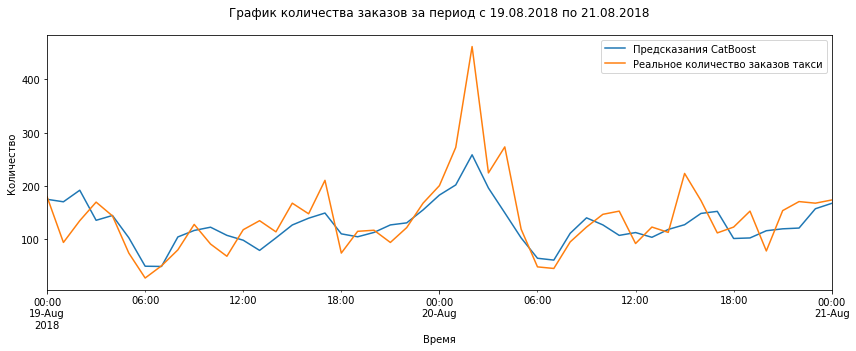

In [19]:
pd.DataFrame(index = features_test.index, data = test_pred_cat)[date_1:date_2].plot(ax=plt.gca(),figsize=(12,5))
target_test[date_1:date_2].plot(ax=plt.gca(),figsize=(12,5))

plt.legend(['Предсказания CatBoost', 'Реальное количество заказов такси'])
plt.title('График количества заказов за период c 19.08.2018 по 21.08.2018', y=1.05)
plt.xlabel('Время')
plt.ylabel('Количество')
plt.tight_layout()

Предсказания относительно точны, но единичные пиковые значения у модели слабо получается предсказывать.

### Вывод

Лучше всего на тестовой выборке показал себя **CatBoost** с показателем RMSE = 40.1.

## Итоговый вывод

Целью настоящего исследования ставилось создание модели, способной предсказать спрос на услуги такси с отклонением до 48 заказов в час.

Анализ данных показал заметную сезонность - пиковые нагрузки приходятся на 17 часов, тогда как минимальное количество заказов поступает ранним утром (6-7 часов). На основании этих данных можно создать рекомендацию о дополнительном увеличении количества экипажей такси именно в эти часы.

В ходе исследования были протестированы 3 модели - **логистическая регрессия**, **случайный лес** и **CatBoost**, и все они показали значение RMSE на тестовой выборке меньше 48. Лучший показатель у **CatBoost**.

Цели и задачи исследования достигнуты, однако для улучшения метрики стоит взять больший период времени или найти дополнительные фичи (например, ввести признаки праздничных и выходных дней).